# Audio Classifier

In [1]:
import os

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE

In [2]:
RANDOM_STATE = 44

def seed():
    np.random.seed(RANDOM_STATE)

seed()

In [3]:
FIG_PATH = "figures"
if not os.path.isdir(FIG_PATH):
    os.mkdir(FIG_PATH)

def save_plot(name):
    plt.savefig(os.path.join(FIG_PATH, name + ".pdf"), bbox_inches="tight")

## Import vowels dataset

In [4]:
data_train_vowels = np.loadtxt("ae.train")
data_test_vowels = np.loadtxt("ae.test")

In [5]:
def get_labels(data, block_lens):
    """
    return format of X:
        - array of recordings
        - per recording:
            - each row is a recording frame (time step), beware varies! 
            - each column is a channel (always 12)
    """
    X = []
    y = []
    prev_row_idx = 0
    speaker_num = 0
    count = 0

    for i in range(data.shape[0]): # go through all rows
        
        # check each row 
        # rows of 1 indicate new recording
        if np.all(data[i,:] == 1):
            
            X.append(data[prev_row_idx:i,:])
            prev_row_idx = i + 1 # plus 1 to not include row of 1's
            
            y.append(speaker_num)
            count += 1 # count examples per speaker
            
            if count == block_lens[speaker_num]:
                count = 0
                speaker_num += 1 # next class
                
    return X, y

In [6]:
train_block_lens = [30] * 9
test_block_lens = [31, 35, 88, 44, 29, 24, 40, 50, 29]

X_train_vowels, y_train_vowels = get_labels(data_train_vowels, train_block_lens)
X_test_vowels, y_test_vowels = get_labels(data_test_vowels, test_block_lens)

## Inspect vowels dataset

In [7]:
COLORS = sns.color_palette("Spectral",n_colors=12)

def plot_recording(ax, rec_data, title=None):
    [ax.plot(x, color=COLORS[i]) for i, x in enumerate(rec_data)]
    ax.set_xlim(0, 22)
    ax.set_ylim(-1.5, 2)
    if title:
        ax.title.set_text("$\it{" + title + "}$")

In [8]:
def add_axis_labels(fig):
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Time Step")
    plt.ylabel("LPCC")

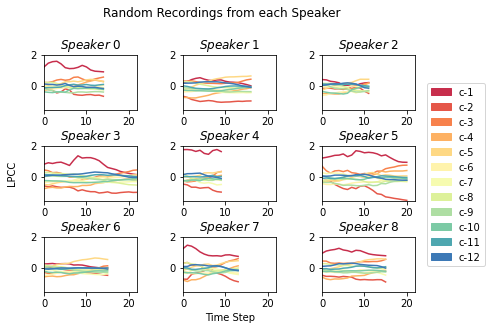

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.tight_layout(pad=1.5)


max_range = 30
min_range = 0
count = 0

for row in ax:
    for col in row:
        random_point = np.random.randint(min_range, max_range)
        min_range += 30
        max_range += 30
        plot_recording(col, X_train_vowels[random_point].T, title="Speaker \;" + str(count))
        count += 1

seed()
add_axis_labels(fig)
fig.suptitle("Random Recordings from each Speaker", y=1.1)
patches = [mpatches.Patch(color=c, label="c-" + str(i + 1)) for i, c in enumerate(COLORS)]
plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.9))
save_plot("rand_speakers")
plt.show()

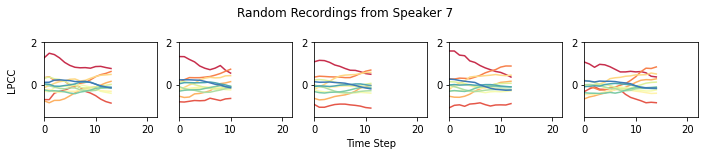

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
speaker = 7

for i, col in enumerate(ax):
    plot_recording(col, X_train_vowels[np.random.randint(speaker * 30, (speaker * 30) + 30)].T)

seed()
add_axis_labels(fig)
fig.suptitle("Random Recordings from Speaker " + str(speaker), y=1.1)
fig.tight_layout(pad=0)
save_plot("speaker_" + str(speaker))
plt.show()

In [11]:
def plot_rec_len_freq(data_ls, title, xlab="Recording Length"):
    lens = [x.shape[0] for x in data_ls]
    min_, max_ = min(lens), max(lens)
    print("Min length:", min_, "Max length:", max_)
    plt.hist(lens)
    plt.xlim(0, 30)
    plt.xlabel(xlab)
    plt.ylabel("Frequency")
    plt.title(title)
    save_plot(title + "rec_len")
    plt.show()

Min length: 7 Max length: 26


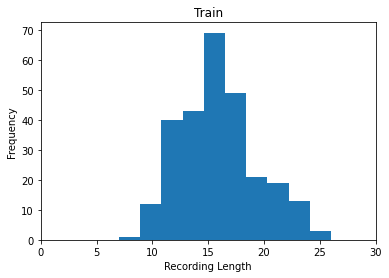

Min length: 7 Max length: 29


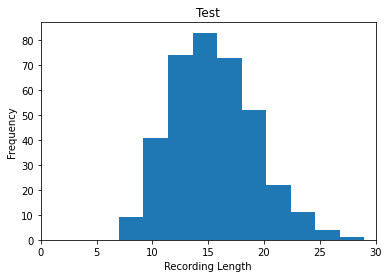

In [12]:
plot_rec_len_freq(X_train_vowels, "Train")
plot_rec_len_freq(X_test_vowels, "Test")

## Preprocess vowels

In [13]:
REC_LEN = 15

def uniform_scaling(X, new_len=REC_LEN):
    """
    Stretch all recordings to length new_len using linear interpolation
    returns new copy of X with modified elements
    """
    X_modified = []

    for rec in X:
        rec = rec.T
        current_len = rec.shape[1]
        
        new_rec = np.zeros((12, new_len))
        new_rec.fill(np.nan)
        
        # indices of scaled array where old values get copied to
        idxs = np.linspace(0, new_len - 1, current_len).round().astype(int)

        for i in range(12):
            new_rec[i, idxs] = rec[i, :] # copy values
            new_rec[i, :] = pd.Series(new_rec[i, :]).interpolate(method="linear") # fill-in nan values
        
        X_modified.append(new_rec.T)

    return X_modified

X_train_vowels_uni = uniform_scaling(X_train_vowels)
X_test_vowels_uni = uniform_scaling(X_test_vowels)

## Feature extraction vowels

In [14]:
def extract_features(X, n_windows=3):
    """
    Extract mean, standard deviation and slope from each window
    """
    assert REC_LEN % n_windows == 0, "Cannot split windows equally!"
    
    n_feat = 3
    X_feat = np.zeros((len(X), 12 * n_feat * n_windows))
    
    for i, recording in enumerate(X):
        
        recordings = np.split(recording.T, n_windows, axis=1)
        
        for k, rec in enumerate(recordings):
            
            for j, channel_y in enumerate(rec):

                x = np.arange(len(channel_y)).reshape(-1, 1)
                y_flat = channel_y.reshape(-1, 1)
                reg = LinearRegression().fit(x, y_flat)
                slope = reg.coef_[0][0]

                mean = np.mean(channel_y)
                std = np.std(channel_y)

                feats = np.array([slope, mean, std])

                idx = (j * n_feat) * (k + 1)
                X_feat[i, idx:idx + n_feat] = feats

    return X_feat

X_feat_train_vowels = extract_features(X_train_vowels_uni)
X_feat_test_vowels = extract_features(X_test_vowels_uni)

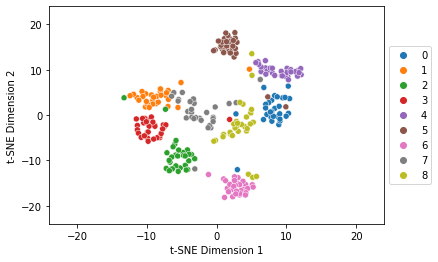

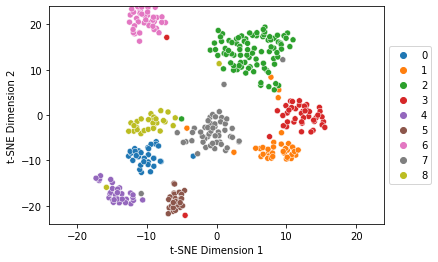

In [15]:
palette = dict(zip(np.arange(0, 9), sns.color_palette(n_colors=9)))

def plot_tsne(x, y, lim=24, palette=palette):
    tsne = TSNE(n_components=2, init='random', random_state=RANDOM_STATE, learning_rate='auto')
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette=palette)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_tsne(X_feat_train_vowels, y_train_vowels)
plot_tsne(X_feat_test_vowels, y_test_vowels)

Accuracy 0.9783783783783784
F1-Score 0.9784714959240361


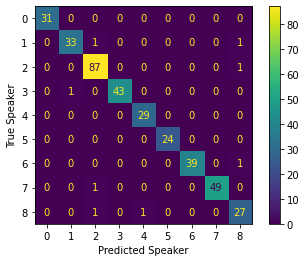

In [16]:
# model = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=RANDOM_STATE)), 
#                                      ('svm', SVC(random_state=RANDOM_STATE)), 
#                                      ('gnb', GaussianNB()),
#                                      ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
#                                      ('knn', KNeighborsClassifier()),
#                                     ], voting='hard')

model = SVC(random_state=RANDOM_STATE)

X_feat_train_shuffle, y_train_shuffle = shuffle(X_feat_train_vowels, y_train_vowels, random_state=RANDOM_STATE)

model.fit(X_feat_train_shuffle, y_train_shuffle)

y_pred = model.predict(X_feat_test_vowels)
print("Accuracy", accuracy_score(y_test_vowels, y_pred))
print("F1-Score", f1_score(y_test_vowels, y_pred, average='weighted'))

cm = confusion_matrix(y_test_vowels, y_pred)
cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot()
plt.xlabel("Predicted Speaker")
plt.ylabel("True Speaker")
plt.show()